# Introducción

En esta práctica vamos a entrenar varios clasificadores sobre un mismo dataset, usando todos los algoritmos de clasificación que hemos visto hasta ahora e implementándolos usando las librerías adecuadas.

# Dataset

El dataset que usaremos es "Breast Cancer Wisconsin (Diagnostic)", disponible en [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)
También está disponible directamente en `sklearn.datasets.load_breast_cancer()`.

**Descripción del dataset**


| Aspecto                 | Detalle                                                   |
| ----------------------- | --------------------------------------------------------- |
| **Tipo de problema**    | Clasificación binaria                                     |
| **Objetivo**            | Diagnosticar si un tumor es *maligno* (1) o *benigno* (0) |
| **Número de muestras**  | 569                                                       |
| **Número de variables** | 30 características numéricas                              |
| **Balance de clases**   | Moderadamente balanceado (~37% malignos, ~63% benignos)   |

# Métrica

Elige la métrica adecuada para evaluar tus modelos. Justifica tu respuesta.

El dataset no está perfectamente balanceada, por lo que accuracy puede inducir sesgos (un modelo que siempre predice “benigno” tendría ~63% de acierto).

El AUC-ROC mide la capacidad discriminativa del modelo (qué tan bien separa positivos y negativos) independientemente del umbral, y es más informativa cuando las clases son desiguales.

Es además aplicable y comparable entre modelos probabilísticos (Naïve Bayes, Regresión Logística, Redes Bayesianas) y no probabilísticos (CART).

# 1. Cargar el dataset e importar librerías

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

In [110]:
# Cargar dataset
data = datasets.load_breast_cancer()

# Separar X e y
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

In [111]:
type(data)

sklearn.utils._bunch.Bunch

In [112]:
type(data.data)

numpy.ndarray

In [113]:
print(data.data)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


Información detallada sobre el dataset:

In [114]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

Veamos cómo son las clases:

In [115]:
print(data.target_names)

print(np.unique(data.target))


['malignant' 'benign']
[0 1]


Por lo tanto, este dataset no sigue la convención usual y tenemos que:

0 -> 'malignant'

1 -> 'benign'

In [116]:
# Cargar como dataframe, con y en la columna llamada 'target'
df = pd.DataFrame(X, columns=data.feature_names)
df['target']=y

y = 1 - data.target

print("Clase (counts):")
print(df['target'].value_counts())


Clase (counts):
target
1    357
0    212
Name: count, dtype: int64


In [117]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# 2. Análisis exploratorio

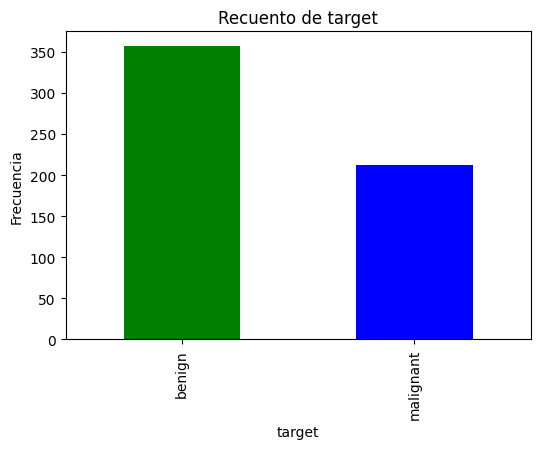

In [118]:
# Histograma por clase

plt.figure(figsize=(6,4))
df['target'].replace({0:'malignant', 1:'benign'}).value_counts().plot(kind='bar', color=['green', 'blue'])
plt.ylabel('Frecuencia')
plt.title('Recuento de target')
plt.show()

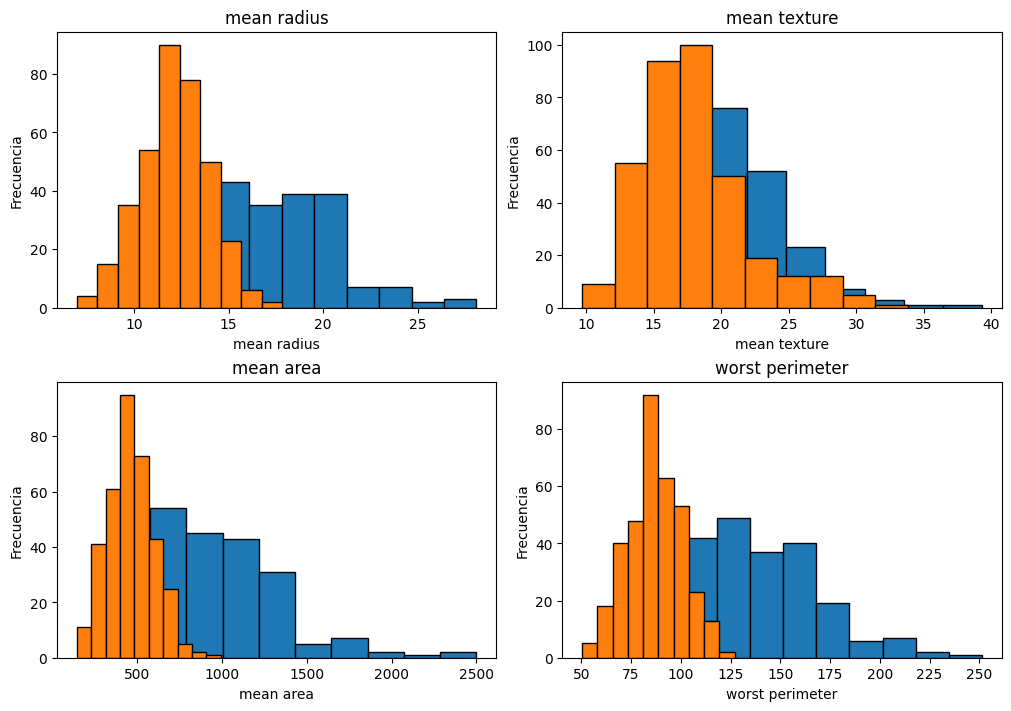

In [119]:
# Histogramas de algunas variables por clase

cols = ['mean radius', 'mean texture', 'mean area', 'worst perimeter']

fig, axs = plt.subplots(2, 2, figsize=(10, 7), constrained_layout=True)
axs = axs.ravel() #Aplana para iterar

for ax, col in zip(axs, cols): # Itera en las dos arrays a la vez
    x0 = df.loc[df['target']==0, col] # Devuelve la columna col cuando clase 0
    x1 = df.loc[df['target']==1, col] # Devuelve la columna col cuando clase 1

    ax.hist(x0, edgecolor='k', label='Clase 0')
    ax.hist(x1, edgecolor='k', label='Clase 1')
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')

plt.show()

Text(0.5, 1.02, 'Pairplot por clase')

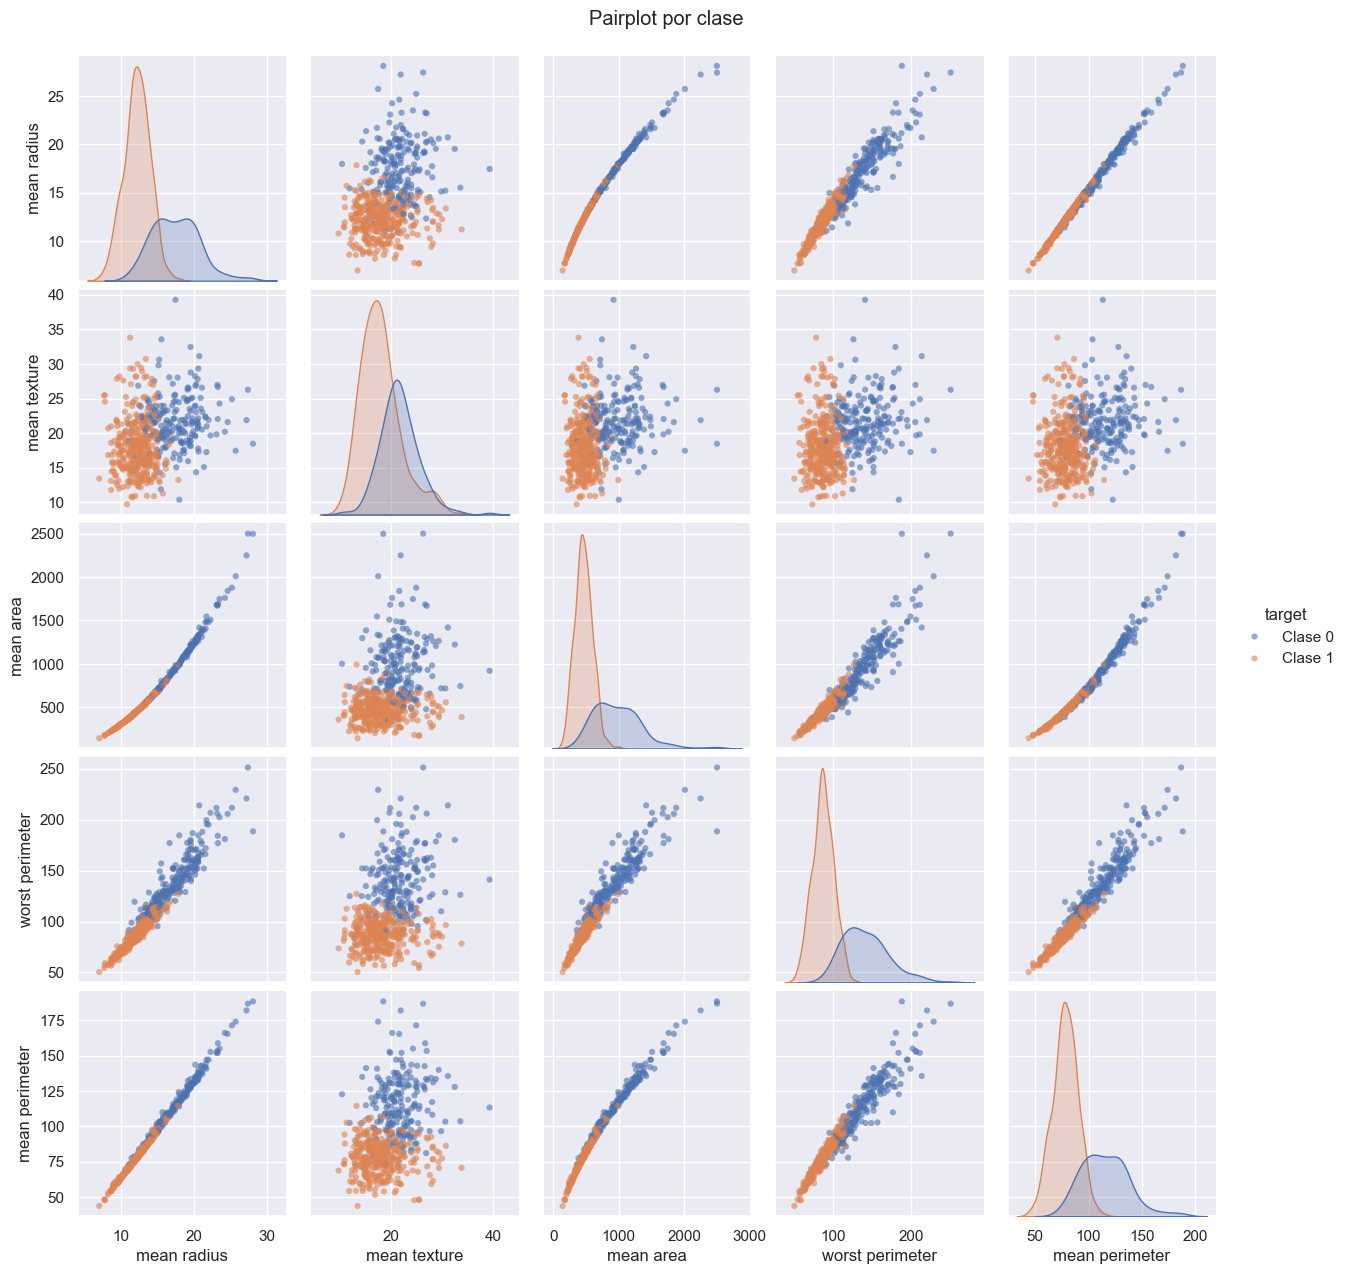

In [136]:
# Todos los pairplots posibles, segmentados por clase.
# Usa Seaborn pairplot
cols = ['mean radius', 'mean texture', 'mean area', 'worst perimeter', 'mean perimeter']

df_plot = df[cols + ['target']].copy()        # <--- aquí
df_plot['target'] = df_plot['target'].map({0: 'Clase 0', 1: 'Clase 1'})

sns.set_theme()
g = sns.pairplot(
    df_plot,
    hue='target',
    vars=cols,
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'},
    corner=False
)
g.fig.suptitle('Pairplot por clase', y=1.02)

In [121]:
# Estadísticas descriptivas
print(df.describe().T[['mean', 'std', 'min', 'max']])

                               mean         std         min         max
mean radius               14.127292    3.524049    6.981000    28.11000
mean texture              19.289649    4.301036    9.710000    39.28000
mean perimeter            91.969033   24.298981   43.790000   188.50000
mean area                654.889104  351.914129  143.500000  2501.00000
mean smoothness            0.096360    0.014064    0.052630     0.16340
mean compactness           0.104341    0.052813    0.019380     0.34540
mean concavity             0.088799    0.079720    0.000000     0.42680
mean concave points        0.048919    0.038803    0.000000     0.20120
mean symmetry              0.181162    0.027414    0.106000     0.30400
mean fractal dimension     0.062798    0.007060    0.049960     0.09744
radius error               0.405172    0.277313    0.111500     2.87300
texture error              1.216853    0.551648    0.360200     4.88500
perimeter error            2.866059    2.021855    0.757000    2

In [122]:
# Matriz de correlaciones entre las variables
# Para calcular las correlaciones necesitas la función `corr``

In [123]:
# Top correlaciones con el target

# 3. Separación train/test

In [124]:
# Config reproducible
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [125]:
# Separa train y test ysando la función adecuada de scikit-learn.
# Usa el parámetro random_state=RANDOM_STATE para controlar la aleatoriedad
# X_train, X_test, y_train, y_test = 

La regresión logística se entrena mediante descenso del gradiente, y la escala de las variables afecta la velocidad y estabilidad numérica del entrenamiento. Si las variables tienen órdenes de magnitud distintos, los gradientes también lo tendrán, y el proceso puede converger mal o lentamente.

Por este motivo, estandariza los datos usando `StandardScaler` —es decir, restar la media y dividir por la desviación típica.

In [126]:
#scaler = 
#X_train_std = 
#X_test_std = 

# 4. Entrenar modelos clásicos


## Regresión logística

In [127]:
# Usa LogisticRegression para ajustar una regresión logística


In [128]:
# Realiza predicciones sobre test
# y_test_hat = 

Podemos ver no sólo la clase predicha, sino la probabilidad que asigna a cada clase:

In [129]:
# Usa `predict_proba``
#y_test_proba = 

In [130]:
# Cálculo de AUC
proba_log = log_clf.predict_proba(X_test_std)[:, 1]
auc_log = roc_auc_score(y_test, proba_log)
print(f"Logistic Regression AUC: {auc_log}")

NameError: name 'log_clf' is not defined

## Naive Bayes (GaussianNB)

In [ ]:
# Naive Bayes usando GaussianNB
#nb_clf = 
#proba_nb = nb_clf.predict_proba(X_test_std)[:,1]
#auc_nb = roc_auc_score(y_test, proba_nb)
print(f"GaussianNB AUC: {auc_nb}")

## Árbol de decisión

In [ ]:
# Árbol de decisión (CART) usando DecisionTreeClassifier
#tree_clf = 

proba_tree = tree_clf.predict_proba(X_test_std)[:,1]
auc_tree = roc_auc_score(y_test, proba_tree)

print(f"CART AUC: {auc_nb}")

# 5. Red Bayesiana 

Implementa la red bayesiana con `pgmpy`.

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif

Seleccionamos un subconjunto de features (top K) para reducir la complejidad

In [ ]:
K = 6

mi = mutual_info_classif(X_train, y_train, random_state=42)
top_idx = np.argsort(mi)[-K:][::-1]
top_features = feature_names[top_idx]
print("Usando estas variables para la red bayesiana:", list(top_features))

Discretizamos estas features (KBins) usando cuantiles para mantener interpretación

In [ ]:
# Discretizar variables usando KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train_disc = kbd.fit_transform(X_train[:, top_idx])
X_test_disc = kbd.transform(X_test[:, top_idx])

# Construimos DataFrame discreto para pgmpy
cols = [f"X{i}" for i in range(K)]
df_train_bn = pd.DataFrame(X_train_disc, columns=cols)
df_train_bn["target"] = y_train.astype(int)

In [ ]:
# Estructura de Naïve Bayes: target -> cada feature
edges = [("target", f"X{i}") for i in range(K)]
bn_model = DiscreteBayesianNetwork(edges)

# Ajustamos los parámetros por máxima verosimilitud
bn_model.fit(df_train_bn, estimator=MaximumLikelihoodEstimator)

# Inferencia
infer = VariableElimination(bn_model)

# Predicción de probabilidades para test
def bn_predict_proba_row(row_disc):
    evidence = {f"X{i}": int(row_disc[i]) for i in range(K)}
    q = infer.query(variables=["target"], evidence=evidence, show_progress=False)
    return float(q.values[1])  # probabilidad de clase 1 (benign)

proba_bn = np.array([bn_predict_proba_row(row) for row in X_test_disc])
auc_bn = roc_auc_score(y_test, proba_bn)
print(f"AUC - Red bayesiana (Naïve Bayes manual): {auc_bn:.4f}")


# 6. Comparación: ROC curves

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, proba_log)
fpr_nb, tpr_nb, _ = roc_curve(y_test, proba_nb)
fpr_tree, tpr_tree, _ = roc_curve(y_test, proba_tree)
fpr_bn, tpr_bn, _ = roc_curve(y_test, proba_bn)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={auc_log:.3f})')
plt.plot(fpr_nb, tpr_nb, label=f'GaussianNB (AUC={auc_nb:.3f})')
plt.plot(fpr_tree, tpr_tree, label=f'DecisionTree (AUC={auc_tree:.3f})')
plt.plot(fpr_bn, tpr_bn, label=f'BayesianNet (AUC={auc_bn:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Resultado resumen en DataFrame

results = pd.DataFrame({
    'model': ['LogisticRegression','GaussianNB','DecisionTree','BayesianNetwork'],
    'auc': [auc_log, auc_nb, auc_tree, auc_bn]
})
print(results.sort_values('auc', ascending=False))